<a href="https://colab.research.google.com/github/duskvirkus/ml-art-colabs/blob/adding-notebooks/SinGAN_distortions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SinGAN Distortions

by @duskvirkus

This is a notebook inspired by the [Yuma Kishi's Studies of Collage of Paintings for Humanity](https://obake2ai.com/studies-of-collage-of-paintings-for-humanity) and attempts to replicate the the look of using SinGAN to create distored portions of an image and reconstructing them.

Thanks to Derrick Schultz for much of the basis for this notebook find his SinGAN notebook here: [https://github.com/dvschultz/ai/blob/master/SinGAN.ipynb](https://github.com/dvschultz/ai/blob/master/SinGAN.ipynb)

Additional info on SinGAN:

*   [SinGAN Github repo](https://github.com/tamarott/SinGAN)
*   [ArXiv paper](https://arxiv.org/pdf/1905.01164.pdf)
* [Supplementary Materials paper](https://tomer.net.technion.ac.il/files/2019/09/SingleImageGan_SM.pdf)

## Setup Runtime
Colab needs to know we need to use a GPU-powered machine in order to run this notebook. At the top of this page, click on the `Runtime` tab, then select `Change runtime type`. In the modal that pops up, select `GPU` under the `Hardware accelerator` options.

In [ ]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-a36df85c-3875-deec-2a13-b516647f55ce)


## General Setup

It's recommended that you mount your google drive as you'll lose all work if colab shuts down. However if you choose to process locally that's fine too.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Then we'll download dependancies and setup the file structure.

In [ ]:
import os

%cd /content

if os.path.isdir("/content/drive/MyDrive/colab-sin-distortions"):
    %cd /content/drive/MyDrive/colab-sin-distortions/SinGAN
else:
    if os.path.isdir("/content/drive/"):
      %cd /content/drive/MyDrive/
      !mkdir colab-sin-distortions
      %cd colab-sin-distortions
    !git clone https://github.com/duskvirkus/SinGAN
    %cd SinGAN
    !mkdir originals
    !mkdir inprogress
    !mkdir results

!pip install torch==1.4.0 torchvision==0.5.0 imutils

import cv2
import imutils
import ipywidgets as widgets
from IPython.display import display
from google.colab.patches import cv2_imshow

/content
/content/drive/MyDrive/colab-sin-distortions/SinGAN
     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 45.1MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.4.0 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101


Specify the path of the image you'd like to use.

In [ ]:
img_path = ''

In [ ]:
# or use an example image
img_path = '/content/drive/MyDrive/colab-sin-distortions/SinGAN/Input/martha-rigden-met-oa.png'

## Load Image

In [ ]:
img = cv2.imread(img_path)

Run the following block if you'd like to check if the loading worked correctly.

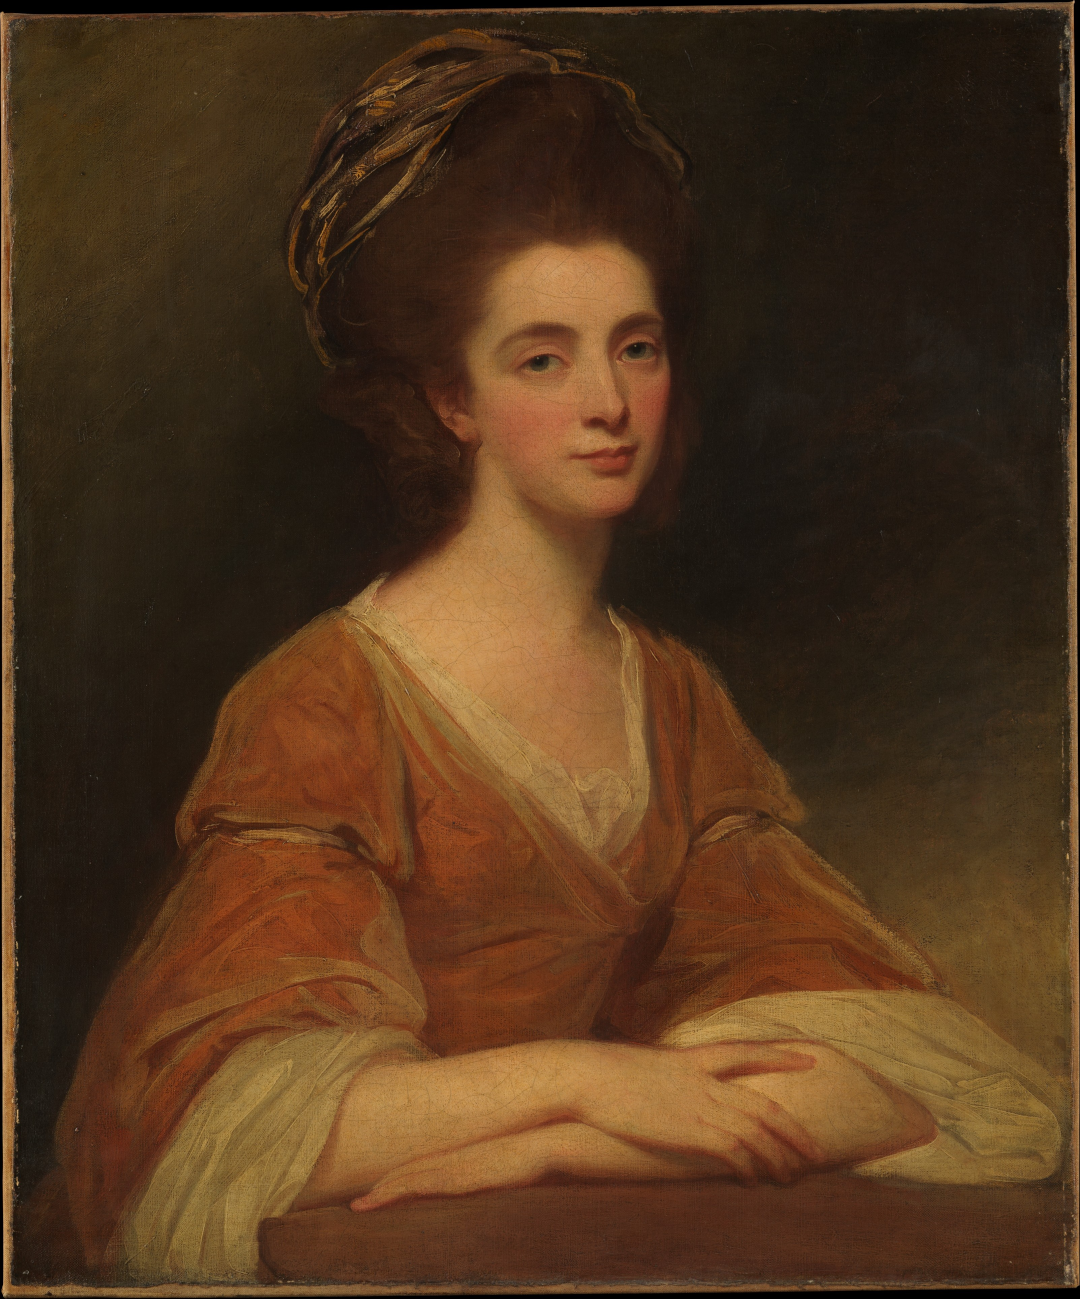

In [ ]:
cv2_imshow(img)

## Select Distortion Area

Use the GUI made by running the cell below to select the area of the image you'd like to have distored with SinGAN. Once you have it don't forget to save it for the next step.

*Note: The image is displayed as a thumbnail for performance purposes.*

In [ ]:
area_img = imutils.resize(img, width=256)

shape = area_img.shape

x_third = shape[1] / 3
y_third = shape[0] / 3

x_start = widgets.IntSlider(value=x_third, max=shape[1])
x_stop = widgets.IntSlider(value=x_third * 2, max=shape[1])
y_start = widgets.IntSlider(value=y_third, max=shape[0])
y_stop = widgets.IntSlider(value=y_third * 2, max=shape[0])

crop_x_start = None
crop_x_stop = None
crop_y_start = None
crop_y_stop = None

display(x_start, x_stop, y_start, y_stop)

update_display_button = widgets.Button(description='update preview')
save_area_button = widgets.Button(description='save distort area')
output = widgets.Output()

def update_pressed(b):
  update_preview()

def update_preview():
  area_img = imutils.resize(img, width=256)
  cv2.rectangle(
    area_img,
    (x_start.value, y_start.value),
    (x_stop.value, y_stop.value),
    (0,255,0),
    1
  )
  output.clear_output()
  with output:
    cv2_imshow(area_img)

def map_value(val, from_min, from_max, to_min, to_max):
  return int((val - from_min) / (from_max - from_min) * (to_max - to_min) + to_min);

def saveImage(img, path, filename, ext):
  if(ext == "png"):
    new_file = os.path.splitext(filename)[0] + ".png"
    if os.path.isfile(new_file):
      os.remove(new_file)
    cv2.imwrite(os.path.join(path, new_file), img, [cv2.IMWRITE_PNG_COMPRESSION, 0])
  elif(ext == "jpg"):
    new_file = os.path.splitext(filename)[0] + ".jpg"
    if os.path.isfile(new_file):
      os.remove(new_file)
    cv2.imwrite(os.path.join(path, new_file), img, [cv2.IMWRITE_JPEG_QUALITY, 90])

def save_area(b):
  area_img = imutils.resize(img, width=256)

  x1 = map_value(x_start.value, 0, area_img.shape[1], 0, img.shape[1])
  x2 = map_value(x_stop.value, 0, area_img.shape[1], 0, img.shape[1])
  y1 = map_value(y_start.value, 0, area_img.shape[0], 0, img.shape[0])
  y2 = map_value(y_stop.value, 0, area_img.shape[0], 0, img.shape[0])

  img_name = img_path.split('/')[-1].split('.')[0]
  f_name = os.path.join(os.getcwd(), 'inprogress/crop-' + img_name + '.txt')
  if os.path.isfile(f_name):
    os.remove(f_name)
  f = open(f_name, "a")
  f.write(str(x1) + '\n')
  f.write(str(x2) + '\n')
  f.write(str(y1) + '\n')
  f.write(str(y2) + '\n')
  f.close()

  crop_img = img
  crop_img = img[y1:y2, x1:x2]

  img_name = img_path.split('/')[-1]
  saveImage(crop_img, os.path.join(os.getcwd(), 'inprogress/'), 'crop-' + img_name, 'png')

  output.clear_output()
  with output:
    print('area saved!')

update_display_button.on_click(update_pressed)
save_area_button.on_click(save_area)
display(update_display_button, save_area_button, output)

update_preview()

IntSlider(value=85, max=256)

IntSlider(value=170, max=256)

IntSlider(value=102, max=307)

IntSlider(value=204, max=307)

Button(description='update preview', style=ButtonStyle())

Button(description='save distort area', style=ButtonStyle())

Output()

## Train SinGAN

This may take awhile.

In [ ]:
crop_path = '/content/drive/MyDrive/colab-sin-distortions/SinGAN/inprogress/crop-martha-rigden-met-oa.png'
dest = 'Input/Images/'
!cp {crop_path} {dest}

In [ ]:
crop_name = 'crop-martha-rigden-met-oa.png'

In [ ]:
!python main_train.py --help

In [ ]:
!python main_train.py --input_name {crop_name}

Random Seed:  7823
GeneratorConcatSkip2CleanAdd(
  (head): ConvBlock(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (LeakyRelu): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (body): Sequential(
    (block1): ConvBlock(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (LeakyRelu): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (block2): ConvBlock(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (LeakyRelu): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (block3): ConvBlock(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

## Generate Frames

In [ ]:
fps = 24
duration = 10 # in seconds
samples = fps * duration
print(samples)
# !python random_samples.py --input_name {crop_name} --mode random_samples --gen_start_scale 1 --num_samples {samples}
os.system("python random_samples.py --input_name {crop_name} --mode random_samples --gen_start_scale 1 --num_samples {samples}".format(crop_name = crop_name, samples = samples))

240


0

In [ ]:
import numpy as np

original = cv2.imread(img_path)
img_name = img_path.split('/')[-1].split('.')[0]
f_name = os.path.join(os.getcwd(), 'inprogress/crop-' + img_name + '.txt')
f = open(f_name, "r")
x1 = int(f.readline())
x2 = int(f.readline())
y1 = int(f.readline())
y2 = int(f.readline())

output_dir = '/content/drive/MyDrive/colab-sin-distortions/SinGAN/Output/RandomSamples/crop-martha-rigden-met-oa/gen_start_scale=0'
for root, dirs, files in os.walk(output_dir):
  for file in files:
    gen = cv2.imread(os.path.join(root, file))

    out = original.copy()
    gen = cv2.resize(gen, (x2-x1, y2-y1))
    out[y1:y2, x1:x2] = gen

    out_path = os.path.join(os.getcwd(), './results/out-' + file)
    cv2.imwrite(out_path, out, [cv2.IMWRITE_PNG_COMPRESSION, 0])


434 683 220 537
/content/drive/MyDrive/colab-sin-distortions/SinGAN/Output/RandomSamples/crop-martha-rigden-met-oa/gen_start_scale=0/0.png
(250, 197, 3)
(317, 249, 3)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
/content/drive/MyDrive/colab-sin-distortions/SinGAN/Output/RandomSamples/crop-martha-rigden-met-oa/gen_start_scale=0/1.png
(250, 197, 3)
(317, 249, 3)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
/content/drive/MyDrive/colab-sin-distortions/SinGAN/Output/RandomSamples/crop-martha-rigden-met-oa/gen_start_scale=0/2.png
(250, 197, 3)
(317, 249, 3)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
/content/drive/MyDrive/colab-sin-distortions/SinGAN/Output/RandomSamples/crop-martha-rigden-met-oa/gen_start_scale=0/3.png
(250, 197, 3)
(317, 249, 3)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
/content/drive/MyDrive/colab-sin-distortions/SinGAN/Output/RandomSamples/crop-martha-rigden-met-oa/gen_start_scale=0/4.png
(250, 197, 3)
(317, 249, 3)
<class 'numpy.ndarray'> <class 'numpy

## Video

In [ ]:
%cd results/
!ffmpeg -framerate {fps} -pattern_type glob -i '*.png' -c:v libx264 -pix_fmt yuv420p out.mp4

/content/drive/My Drive/colab-sin-distortions/SinGAN/results
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --

## GIF

In [ ]:
!apt install imagemagick
!convert *.png out.gif

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono ghostscript gsfonts
  imagemagick-6-common imagemagick-6.q16 libcupsfilters1 libcupsimage2
  libdjvulibre-text libdjvulibre21 libgs9 libgs9-common libijs-0.35
  libjbig2dec0 liblqr-1-0 libmagickcore-6.q16-3 libmagickcore-6.q16-3-extra
  libmagickwand-6.q16-3 libnetpbm10 libwmf0.2-7 netpbm poppler-data
Suggested packages:
  fonts-noto ghostscript-x imagemagick-doc autotrace cups-bsd | lpr | lprng
  enscript gimp gnuplot grads hp2xx html2ps libwmf-bin mplayer povray radiance
  sane-utils texlive-base-bin transfig ufraw-batch inkscape libjxr-tools
  libwmf0.2-7-gtk poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fonts-arphic-ukai
  fonts-arphic-uming fonts-nanum
The following NEW packages will be installed:
  fonts-droid-fallback fonts-noto-mono g